# LEAP Model Validation

This notebook presents validation results for the LEAP (Lifetime Exposures and Asthma outcomes Projection) model. The objective is to compare key simulated outputs from the current pythonic version to observed targets. The taregts include demographic trends, asthma prevalence and incidence, risk factor distributions, and asthma-related health outcomes.

A large sample run of LEAP was used to generate all of the data files used in this notebook.


## Notebook setup

### Environment setup

In [60]:
# Environment setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

### Running Simulation to Obtain Data

*Currently, simulations at a sufficient size to get meaningful results take too long to run practically in the notebook. So calling simulation.run() in the Jupyter notebook and using the generated outcome_matrix object for analysis is infeasible. Instead, run it seperately from the command line and use the outputted csvs.*

To run the simulation, open a terminal:

```sh
leap
    --run-simulation
    --path-output PATH/TO/SAVE/OUTPUT/
    --province PROVINCE
    --max-age MAX_AGE
    --min-year STARTING_YEAR
    --time-horizon SIMULATION_LENGTH
    --population-growth-type GROWTH_TYPE
    --num-births-initial N_BIRTHS
    --ignore-pollution
```

**NOTE**: The default simulation folder naming scheme is:

`./leap_output/PROVINCE-MAX_AGE-STARTING_YEAR-SIMULATION_LENGTH-GROWTH_TYPE-N_BIRTHS`

For instance, if the model was run with the following parameters:

```json
"parameters": {
        "province": "CA",
        "max_age": 100,
        "min_year": 2001,
        "time_horizon": 15,
        "population_growth_type": "M3",
        "num_births_initial": 5000,
        "pollution ignored": true,
        "max_year": 2015
    }
```

Then the deafult folder name would be:

``./leap_output/CA-100-2001-15-M3-5000``

### Constants and Parameters

In [61]:
# Constants for this notebook
notebook_path = Path(os.getcwd())
LEAP_ROOT = notebook_path.parent.parent
DATA_FOLDER = LEAP_ROOT / "leap" / "processed_data"

# Simulation parameters
RUN_BUNDLE_NAME = "demo"  # REPLACE WITH YOUR DESIRED SIMULATION RUN
PROVINCE = "CA"
MAX_AGE = 110
STARTING_YEAR = 2001
SIMULATION_LENGTH = 30
GROWTH_TYPE = "M3"
N_BIRTHS = 5000

OUTPUT_FOLDER = LEAP_ROOT / "output" # REPLACE WITH PATH TO THE FOLDER STORING YOUR LEAP OUTPUTS
RUN_BUNDLE_FOLDER = OUTPUT_FOLDER / RUN_BUNDLE_NAME

# Figures

## Mortality Figure

Mortality by sex (left: males; right: females) for the model (grey solid) and Statistics
Canada (black dashed).

### Load Data

In [62]:
# Read obsereved StatsCanada asthma prevalence data
target_mortality_df_raw = pd.read_csv(DATA_FOLDER / "life_table.csv")

# Read mortality data from simulation
model_mortality_df_raw = pd.read_csv(RUN_BUNDLE_FOLDER / "outcome_matrix_death.csv")

# Read population data from simulation
model_alive_df_raw = pd.read_csv(RUN_BUNDLE_FOLDER / "outcome_matrix_alive.csv")

### Process Data

In [63]:
# Filter by ages under 80 years for the figure
target_mortality_df = target_mortality_df_raw[target_mortality_df_raw["age"] <= 80]
# Filter by chosen province
target_mortality_df = target_mortality_df[target_mortality_df["province"] == PROVINCE]

# Filter by ages under 80 years for the figure
model_mortality_df = model_mortality_df_raw[model_mortality_df_raw["age"] <= 80]
# Merge model_mortality_df with model_alive_df to get n_alive for each row
model_mortality_df = model_mortality_df.merge(model_alive_df_raw, on=["year", "age", "sex"])
# Calculate mortality rate as n_deaths / n_alive
model_mortality_df["prob_death"] = model_mortality_df["n_deaths"] / model_mortality_df["n_alive"]

### Visualize Data

In [64]:
# Figure Parameters
figure_years = [2001, 2010, 2015, 2020, 2025, 2030]
num_cols = min(len(figure_years), 3)
num_rows = int(np.ceil(len(figure_years) / num_cols))

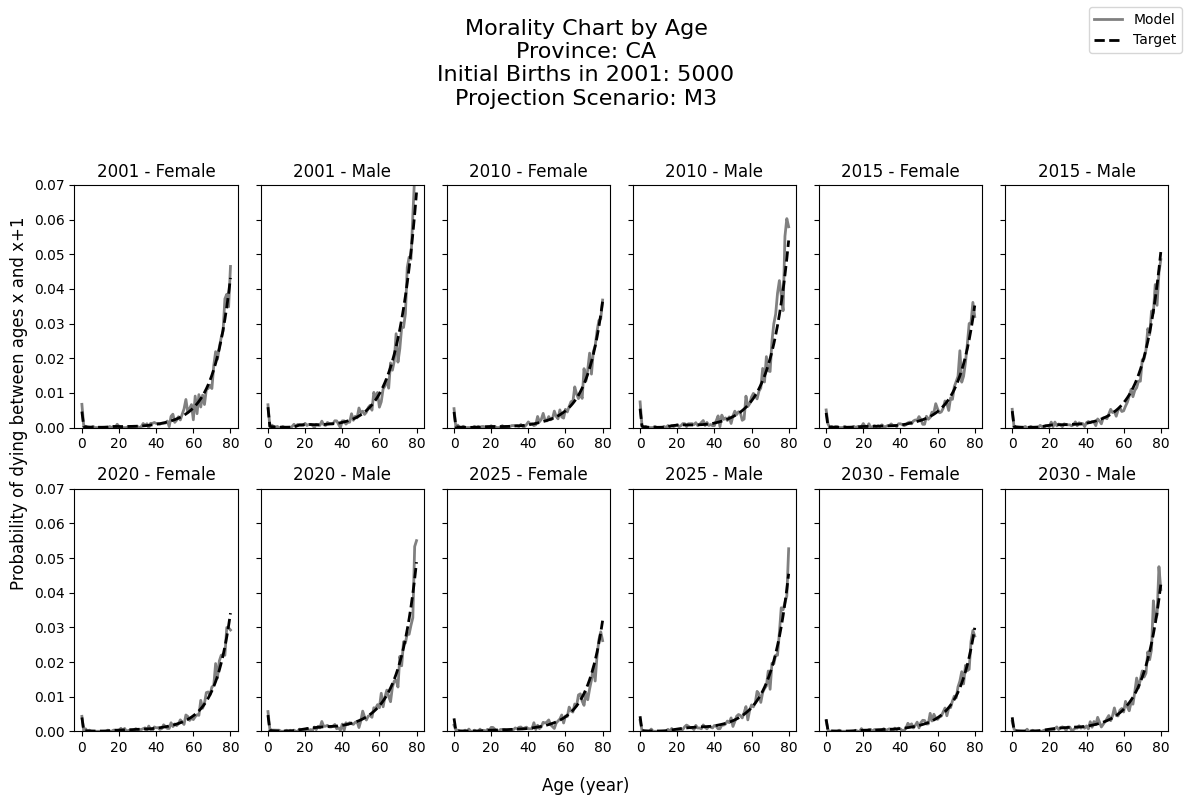

In [ ]:
fig, axs = plt.subplots(
    nrows=num_rows, ncols=num_cols * 2, figsize=(4 * num_cols, 4 * num_rows), sharey=True
)

# Loop over figure years to make one plot per year
for i, year in enumerate(figure_years):
    for j, sex in enumerate(["F", "M"]):
        # Get axis for current plot by indexing with i and j
        if num_rows == 1:
            ax: plt.Axes = axs[i * 2 + j] if num_cols == 1 else axs[i * 2 + j]
        else:
            ax: plt.Axes = axs[i // num_cols][i % num_cols * 2 + j]

        # Filter StatsCan data by current year and sex
        target_mortality_filtered_df = target_mortality_df[
            (target_mortality_df["year"] == year) & (target_mortality_df["sex"] == sex)
        ]
        # Filter simulation data by current year and sex
        model_mortality_filtered_df = model_mortality_df[
            (model_mortality_df["year"] == year) & (model_mortality_df["sex"] == sex)
        ]

        # Plot mortality trend from the model
        ax.plot(
            model_mortality_filtered_df["age"],
            model_mortality_filtered_df["prob_death"],
            color="grey",
            linewidth=2,
        )
        # Plot mortality trend from target
        ax.plot(
            target_mortality_filtered_df["age"],
            target_mortality_filtered_df["prob_death"],
            color="black",
            linestyle="dashed",
            linewidth=2,
        )

        # Set title and axis limits
        ax.set_title(f"{year} - {'Female' if sex == 'F' else 'Male'}", fontsize=12)
        ax.set_ylim(0, 0.07)
        ax.set_xticks([0, 20, 40, 60, 80])

# Additional figure details
fig.supxlabel("Age (year)")
fig.supylabel("Probability of dying between ages x and x+1")
fig.suptitle(
    f"Morality Chart by Age\n"
    + f"Province: {PROVINCE}\n"
    + f"Initial Births in {STARTING_YEAR}: {N_BIRTHS}\n"
    + f"Projection Scenario: {GROWTH_TYPE}",
    fontsize=16,
)
fig.legend(["Model", "Target"])
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()

## Population Pyramid Figure

Population by age across selected years from the model (grey solid) and from Statistics
Canada (black dashed).

### Load Data

In [66]:
# Read population data from Stats Canada
target_pop_df_raw = pd.read_csv(DATA_FOLDER / "birth" / "initial_pop_distribution_prop.csv")

# Read population data from simulation
model_pop_df_raw = pd.read_csv(RUN_BUNDLE_FOLDER / "outcome_matrix_alive.csv")

### Process Data

In [68]:
# Filter to only include dates after chosen starting year
target_pop_df = target_pop_df_raw[(target_pop_df_raw["year"] >= STARTING_YEAR)]
# Rename target column for clarity
target_pop_df = target_pop_df.rename(columns={"n_age": "n_alive_target"})
# Only keep relevent columns
target_pop_df = target_pop_df[["year", "age", "n_alive_target"]]


# Filter to only include dates after chosen starting year
model_pop_df = model_pop_df_raw[model_pop_df_raw["year"] >= STARTING_YEAR]
# Group sexes together for ages and years
model_pop_df = model_pop_df.groupby(["year", "age"]).sum().reset_index()
# Rename model column for clarity
model_pop_df = model_pop_df.rename(columns={"n_alive": "n_alive_model"})

# Merge the filtered Canada population data and simulation population data
population_df = pd.merge(target_pop_df, model_pop_df, on=["year", "age"])

### Visualize Data

In [69]:
# Figure Parameters
figure_years = [2001, 2010, 2015, 2020, 2025, 2030]
num_cols = min(len(figure_years), 3)
num_rows = int(np.ceil(len(figure_years) / num_cols))

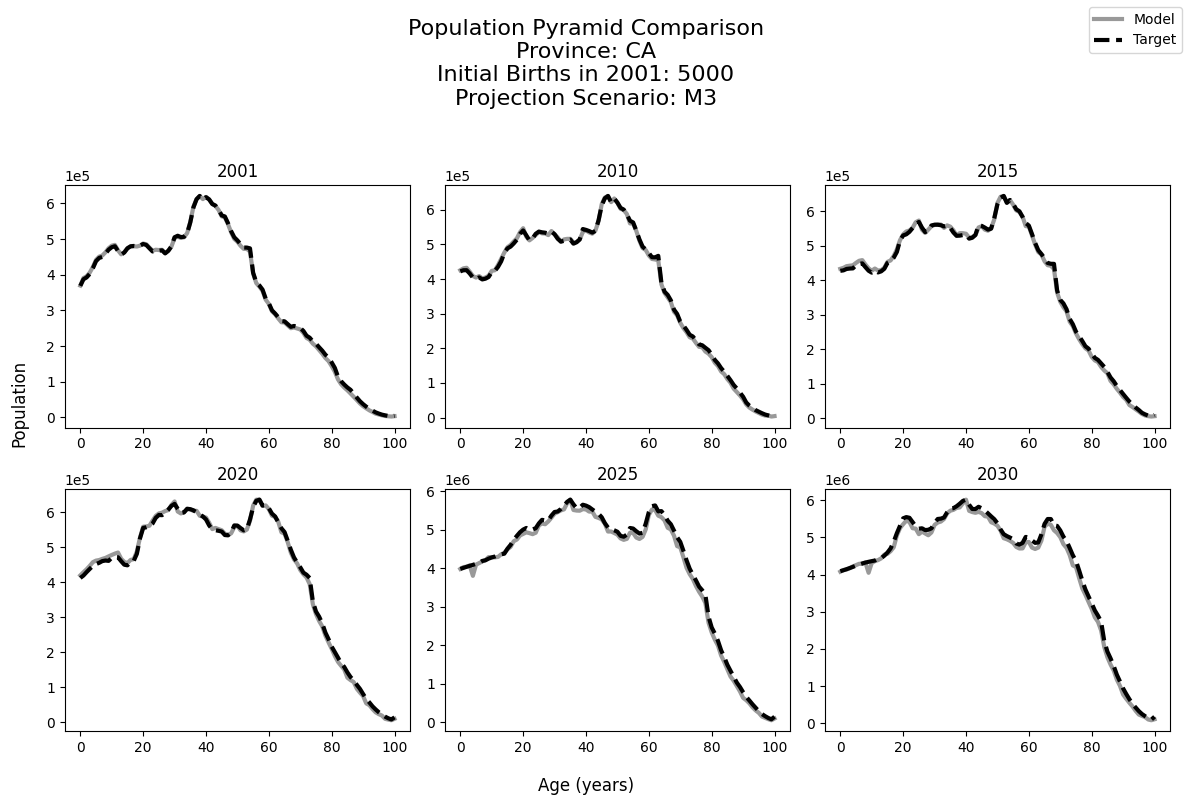

In [ ]:
fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, figsize=(4 * num_cols, 4 * num_rows))

# Loop over figure years to make one plot per year
for i, year in enumerate(figure_years):
    # Get axis for current plot by indexing with i
    if num_rows == 1:
        if num_cols == 1:
            ax: plt.Axes = axs
        else:
            ax: plt.Axes = axs[i % num_cols]
    else:
        ax: plt.Axes = axs[i // num_cols][i % num_cols]

    # Filter by current year
    fig5_filtered_df = population_df[population_df["year"] == year]
    # Group by age and sum over sexes to current number of population for each age
    fig5_filtered_df = fig5_filtered_df.groupby("age").sum().reset_index()

    # Scale the simulation data to match the maximum population of the stats data
    max_stats_age = fig5_filtered_df["n_alive_target"].max()
    max_simulation_age = fig5_filtered_df["n_alive_model"].max()
    scaling_factor = max_stats_age / max_simulation_age
    fig5_filtered_df["n_alive_model"] *= scaling_factor

    # Plot age trend from model
    ax.plot(
        fig5_filtered_df["age"],
        fig5_filtered_df["n_alive_model"],
        color="#999999",
        linestyle="-",
        linewidth=3,
        label="simulated",
    )
    # Plot age trend from target
    ax.plot(
        fig5_filtered_df["age"],
        fig5_filtered_df["n_alive_target"],
        color="black",
        linestyle="dashed",
        linewidth=3,
        label="observed",
    )

    # Title and Labels
    ax.set_title(f"{year}", fontsize=12)
    ax.ticklabel_format(style="scientific", axis="y", scilimits=(0, 0))

# Additional labels
fig.supxlabel("Age (years)")
fig.supylabel("Population")
fig.suptitle(
    f"Population Pyramid Comparison\n"
    + f"Province: {PROVINCE}\n"
    + f"Initial Births in {STARTING_YEAR}: {N_BIRTHS}\n"
    + f"Projection Scenario: {GROWTH_TYPE}",
    fontsize=16,
)
fig.legend(["Model", "Target"])
plt.tight_layout(rect=[0.01, 0, 1, 0.95])


plt.show()

## Infant Antibiotic Exposure Figure

Rate of infant antibiotic prescriptions by sex (red: females; blue: males) for simulated
(solid) and target (dotted) values from the model and the population-based administrative
database, respectively, with the floor rate of 50 per 1,000 (purple).

### Load Data

In [74]:
# Load antibiotic data from StatsCanada
# TODO add data file
# target_abx_df = pd.read_csv(DATA_FOLDER / "InfantAbxBC.csv")

# Load antibiotic data from simulation
model_abx_df_raw = pd.read_csv(RUN_BUNDLE_FOLDER / "outcome_matrix_antibiotic_exposure.csv")

# Load additional simulation data for population comparisson
model_infant_alive_df_raw =pd.read_csv(RUN_BUNDLE_FOLDER / "outcome_matrix_alive.csv")
model_infant_death_df_raw = pd.read_csv(RUN_BUNDLE_FOLDER / "outcome_matrix_death.csv")
model_infant_emigration_df_raw = pd.read_csv(RUN_BUNDLE_FOLDER / "outcome_matrix_emigration.csv")

### Process Data

In [75]:
# Merge all datasets on Year, Sex, and Age
model_abx_df = model_abx_df_raw.rename(columns={'n_antibiotic_exposure': 'n'}).merge(
    model_infant_alive_df_raw, on=['year', 'sex', 'age']
).merge(
    model_infant_death_df_raw, on=['year', 'sex', 'age']
).merge(
    model_infant_emigration_df_raw, on=['year', 'sex', 'age']
)

# Filter for age 0
model_abx_df = model_abx_df[model_abx_df['age'] == 0].copy()

# Compute total population (N) and rate per 1,000
model_abx_df["N"] = model_abx_df["n_alive"] + model_abx_df["n_deaths"] + model_abx_df["n_emigrants"]
model_abx_df["rate"] = (model_abx_df["n"] / model_abx_df["N"]) * 1000

# Map sex values for labeling
model_abx_df["sex"] = model_abx_df["sex"].map({"F": "Female", "M": "Male"})

### Visualize Data

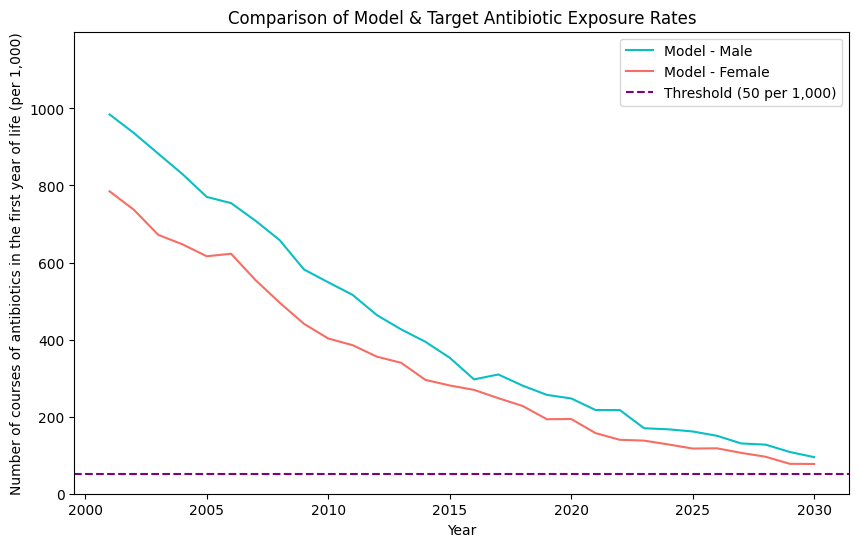

In [77]:
# Define colors to plot for different sexs
sex_colour_dict = {"Male": "#09bfc4", "Female": "#f86d63"}


plt.figure(figsize=(10, 6))

# Plot inftant abx data from simulation
for gender in ["Male", "Female"]:
    subset = model_abx_df[model_abx_df["sex"] == gender]
    plt.plot(subset["year"], subset["rate"],
             label=f"Model - {gender}", color=sex_colour_dict[gender])

# Plot target infant abx data
# for gender in ["Male", "Female"]:
#     subset = target_abx_df[target_abx_df["sex"] == gender]
#     plt.plot(subset["year"], subset["rate"], linestyle="dashed",
#              label=f"Target - {gender}", color=sex_colour_dict[gender])

# Add horizontal reference line
plt.axhline(y=50, color="purple", linestyle="dashed", label="Threshold (50 per 1,000)")

# Labels, legend, and formatting
plt.xlabel("Year")
plt.ylabel("Number of courses of antibiotics in the first year of life (per 1,000)")
plt.ylim(0, 1199)
plt.legend()
plt.title("Comparison of Model & Target Antibiotic Exposure Rates")

plt.show()